In [1]:
# install SHANGRLA from local directory
!pip install -e ../../SHANGRLA

Obtaining file:///Users/Jake/Dropbox/RLAs/SHANGRLA
  Installing build dependencies ... one
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... one
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for shangrla (pyproject.toml) ... one
  Created wheel for shangrla: filename=shangrla-0.1.0-0.editable-py3-none-any.whl size=17608 sha256=d268a76b19f2fabf67832dba9f489a73e28df543ba45c64757a80f947701e15e
  Stored in directory: /private/var/folders/zt/byjw_s1s4g5b01_cjmqw49480000gn/T/pip-ephem-wheel-cache-q7g6sc3s/wheels/c6/9d/bd/003bf7fc78ab0519a2f02830c16dcbde75f331b936bafa0fc4
Successfully built shangrla
  Attempting uninstall: shangrla
    Found existing installation: shangrla 0.1.0
    Uninstalling shangrla-0.1.0:
      Successfully uninstalled shangrla-0.1.0


In [2]:
import math
import json
import warnings
import numpy as np
import pandas as pd
import csv
import copy
import matplotlib.pyplot as plt
import scipy as sp
import itertools
import random
import time

import glob
import os, sys

from collections import OrderedDict
from IPython.display import display, HTML

from cryptorandom.cryptorandom import SHA256, int_from_hash
from cryptorandom.sample import sample_by_index

from shangrla.core.Audit import Audit, Assertion, Assorter, Contest, CVR, Stratum
from shangrla.core.NonnegMean import NonnegMean
from shangrla.formats.Dominion import Dominion

from utils import Bets, Allocations, Weights, mart, lower_confidence_bound, global_lower_bound,\
    intersection_mart, plot_marts_eta, construct_exhaustive_eta_grid, selector,\
    construct_eta_grid_plurcomp, construct_eta_bands, simulate_plurcomp, PGD, convex_uits,\
    banded_uits, brute_force_uits, generate_oneaudit_population

### SF CVR download info
Download the SF CVRs from https://sfelections.org/results/20241105w/detail.html 

Under the 'Final Report' tab click "Cast Vote Record (Raw data) - JSON" to download a zip file with all the CVRs. You will edit the file path for 'cvr_file' below based on where you put the CVR folder once downloaded.

### Define audit parameters

In [3]:
audit = Audit.from_dict({
         'seed':           12345678901234567890,
         'sim_seed':       314159265,
         'cvr_file':       './sf-cvrs-2024/CvrExport_*.json', # Edit with your file path
         'manifest_file':  './sf-cvrs-2024/BallotTypeManifest.json',
         'sample_file':    '...', # EDIT
         'mvr_file':       '...', # EDIT
         'log_file':       '...', # EDIT
         'quantile':       0.8,
         'error_rate_1':   0.0,
         'error_rate_2':   0.0,
         'reps':           100,
         'strata':         {'stratum_1': {'max_cards':   1603908, 
                                          'use_style':   True,
                                          'replacement': False
                                         }
                           }
        })

### Read CVRs

In [4]:
## Read the CVRs
# Group = 1 is precinct, 2 is vote-by-mail
# tally_pool will give precinct, pool will indicate if has CVRs
cvr_list = []
for _fname in glob.glob(audit.cvr_file):
    cvr_list.extend(Dominion.read_cvrs(_fname, use_current=True, enforce_rules=True, include_groups=[1,2],
                                      pool_groups=[1]))

### Tabulate votes cast and display for mayoral contest

In [5]:
# Tabulate votes for each contest
vote_tabulation = CVR.tabulate_votes(cvr_list)

In [6]:
# Mayor contest is contest ID 18
print(vote_tabulation['18']) # votes for candidates
print(sum(vote_tabulation['18'].values())) # total votes

# President contest is contest ID 1
# print(vote_tabulation['1']) # votes for candidates
# print(sum(vote_tabulation['1'].values())) # total votes

defaultdict(<class 'int'>, {'55': 204829, '57': 257051, '62': 243460, '65': 31455, '64': 117898, '61': 192214, '54': 43067, '56': 53638, '58': 54318, '66': 68829, '59': 49611, '60': 34424, '63': 51138, '173': 29, '176': 9, '175': 10})
1401980


In [7]:
# count number of CVRs with mayoral contest
mayor = 0
for cvr in cvr_list:
    if cvr.has_contest('18'):
        mayor = mayor + 1

print(mayor)

410105


### Define contest dict

In [8]:
# Mayoral contest
contest_dict = {
               '18':{
                   'name': 'MAYOR',
                   'risk_limit':       0.05,
                   'cards':            410105,
                   'choice_function':  Contest.SOCIAL_CHOICE_FUNCTION.IRV,
                   'n_winners':        1,
                   'candidates':       ['54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '173', '175', '176'],
                   'winner':           ['57'],
                   'assertion_file':   './November_2024_Mayor/contest_18_assertions.json',
                   'audit_type':       Audit.AUDIT_TYPE.ONEAUDIT,
                   'test':             NonnegMean.betting_mart,
                   'bet':              NonnegMean.kelly_optimal
                  }
               }

# contest_dict = {
#                '1':{
#                    'name': 'PRESIDENT AND VICE PRESIDENT',
#                    'risk_limit':       0.05,
#                    'cards':            412121,
#                    'choice_function':  Contest.SOCIAL_CHOICE_FUNCTION.PLURALITY,
#                    'n_winners':        1,
#                    'candidates':       ['5', '2', '4', '6', '3', '1', '174'],
#                    'winner':           ['5'],
#                    'assertion_file':   None,
#                    'audit_type':       Audit.AUDIT_TYPE.ONEAUDIT,
#                    'test':             NonnegMean.alpha_mart,
#                    'estim':            NonnegMean.shrink_trunc,
#                    'test_kwargs':      {'d': 100, 'f': 0}
#                   }
#                }

contests = Contest.from_dict_of_dicts(contest_dict)

### IRV assertions

In [9]:
# add IRV assertions from the external JSON file
for c in contests:
    if contests[c].choice_function == Contest.SOCIAL_CHOICE_FUNCTION.IRV:
        with open(contests[c].assertion_file, 'r') as f:
            contests[c].assertion_json = json.load(f)['audits'][0]['assertions']

In [10]:
# construct the dict of dicts of assertions for each contest
Assertion.make_all_assertions(contests)

True

### Check CVRs and set tally pools

In [11]:
# check that the CVR IDs are unique
unique_ids = len(set(c.id for c in cvr_list))
print(f'cvrs: {len(cvr_list)} unique IDs: {unique_ids}')
assert unique_ids == len(cvr_list), 'CVR IDs are not unique'

cvrs: 1603908 unique IDs: 1603908


In [12]:
# ensure every CVR in each tally_pool has the same value of `pool`
cvr_list = CVR.check_tally_pools(cvr_list)
len(cvr_list)

1603908

In [13]:
# find the set of tally_pools for which pool==True
pools = set(c.tally_pool for c in cvr_list if c.pool)
len(pools)

4223

In [14]:
# make dict of all contest IDs mentioned in each tally_pool of CVRs for which pool==True
tally_pools = CVR.pool_contests(cvr_list)

# ensure every CVR in each tally_pool for which pool==True has every contest in that tally_pool
CVR.add_pool_contests(cvr_list, tally_pools)

True

In [15]:
Contest.check_cards(contests, cvr_list, force=True)

/Users/Jake/Dropbox/RLAs/SHANGRLA/shangrla/core/Audit.py:2831: UserWarning: 567598 cards contain contest 18 but upper bound is 410105
  warnings.warn(f'{found} cards contain contest {c} but upper bound is {con.cards}')


In [16]:
# set pooled assorter means
for con in contests.values():
    for a in con.assertions.values():
        a.assorter.set_tally_pool_means(cvr_list=cvr_list, tally_pools=tally_pools)

### Set and display assorter margins

In [17]:
# reported assorter margins for each assertion, and the minimum margin, which drives the sample sizes
min_margin = Assertion.set_all_margins_from_cvrs(audit=audit, contests=contests, cvr_list=cvr_list)

print(f'minimum assorter margin: {min_margin}')
Contest.print_margins(contests)

minimum assorter margin: 0.05369469237030433
margins in contest 18:
	assertion 62 v 55 elim 54 56 57 58 59 60 61 63 64 65 66: 0.05998259331428235
	assertion 57 v 55 elim 54 56 58 59 60 63 64 65 66: 0.05369469237030433
	assertion 57 v 62 elim 54 55 56 58 59 60 61 63 64 65 66: 0.05924439480054544
	assertion 62 v 61 elim 54 55 56 57 58 59 60 63 64 65 66: 0.06484871334994136
	assertion 57 v 64: 0.0724244976197943
	assertion 57 v 55 elim 54 56 58 59 60 62 63 64 65 66: 0.07740513532464877
	assertion 57 v 55 elim 54 56 58 59 60 61 63 64 65 66: 0.08016413024711144
	assertion 57 v 61 elim 54 55 56 58 59 60 63 64 65 66: 0.08194355864537939
	assertion 57 v 55 elim 54 56 58 59 60 61 62 63 64 65 66: 0.11944897621203743
	assertion 57 v 61 elim 54 55 56 58 59 60 62 63 64 65 66: 0.11794615203013392
	assertion 57 v 66: 0.12430628719621994
	assertion 57 v 59: 0.1509536679128538
	assertion 57 v 54: 0.15234021261526642
	assertion 57 v 58: 0.14435392654660517
	assertion 57 v 56: 0.14085849492070102
	assert

### Generate and view population(s) of overstatement assorters

In [18]:
assertion_names = []
overstatement_pop = {}

for con in contests.values():
    for name, a in con.assertions.items():
        assertion_names.append(name)
        overstatement_pop[name] = []
        #tally_pool_values = a.assorter.count_tally_pool_vals(cvr_list=cvr_list, tally_pools=tally_pools)
        #overstatement_mean = a.overstatement_assorter_mean()
        for c in cvr_list:
            if c.has_contest(con.id):
                overstatement_pop[name].append(a.overstatement_assorter(c, c, use_style = True))
        overstatement_pop[name] = np.array(overstatement_pop[name])

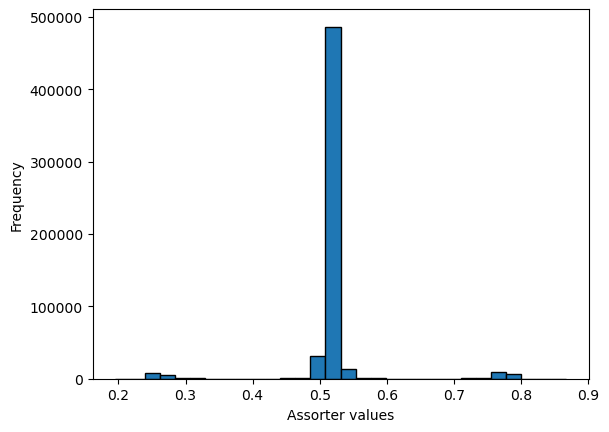

In [19]:
# change index of assertion_names to view different assorter populations
plt.hist(overstatement_pop[assertion_names[5]], bins=30, edgecolor='black')

# Add labels
plt.xlabel("Assorter values")
plt.ylabel("Frequency")

# Display
plt.show()

# Simulate workloads

### Kelly optimal

In [20]:
contest_dict = {
               '18':{
                   'name': 'MAYOR',
                   'risk_limit':       0.05,
                   'cards':            567598,
                   'choice_function':  Contest.SOCIAL_CHOICE_FUNCTION.IRV,
                   'n_winners':        1,
                   'candidates':       ['54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '173', '175', '176'],
                   'winner':           ['57'],
                   'assertion_file':   './November_2024_Mayor/contest_18_assertions.json',
                   'audit_type':       Audit.AUDIT_TYPE.ONEAUDIT,
                   'test':             NonnegMean.betting_mart,
                   'bet':              NonnegMean.kelly_optimal,
                   'test_kwargs': {'d': 100, 'f': 0}
                  }
}
contests = Contest.from_dict_of_dicts(contest_dict)
for c in contests:
    if contests[c].choice_function == Contest.SOCIAL_CHOICE_FUNCTION.IRV:
        with open(contests[c].assertion_file, 'r') as f:
            contests[c].assertion_json = json.load(f)['audits'][0]['assertions']
Assertion.make_all_assertions(contests)
min_margin = Assertion.set_all_margins_from_cvrs(audit=audit, contests=contests, cvr_list=cvr_list)

In [21]:
%%time
sample_size = audit.find_sample_size(contests, cvrs=cvr_list)  
print(f'{sample_size=}\n{[(i, c.sample_size) for i, c in contests.items()]}')

sample_size=112
[('18', 111)]
CPU times: user 1min 14s, sys: 332 ms, total: 1min 14s
Wall time: 1min 14s


### ALPHA

In [22]:
contest_dict = {
               '18':{
                   'name': 'MAYOR',
                   'risk_limit':       0.05,
                   'cards':            567598,
                   'choice_function':  Contest.SOCIAL_CHOICE_FUNCTION.IRV,
                   'n_winners':        1,
                   'candidates':       ['54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '173', '175', '176'],
                   'winner':           ['57'],
                   'assertion_file':   './November_2024_Mayor/contest_18_assertions.json',
                   'audit_type':       Audit.AUDIT_TYPE.ONEAUDIT,
                   'test':             NonnegMean.alpha_mart,
                   'estim':              NonnegMean.shrink_trunc,
                   'test_kwargs': {'d': 100, 'f': 0}
                  }
}
contests = Contest.from_dict_of_dicts(contest_dict)
for c in contests:
    if contests[c].choice_function == Contest.SOCIAL_CHOICE_FUNCTION.IRV:
        with open(contests[c].assertion_file, 'r') as f:
            contests[c].assertion_json = json.load(f)['audits'][0]['assertions']
Assertion.make_all_assertions(contests)
min_margin = Assertion.set_all_margins_from_cvrs(audit=audit, contests=contests, cvr_list=cvr_list)

In [23]:
%%time
sample_size = audit.find_sample_size(contests, cvrs=cvr_list)  
print(f'{sample_size=}\n{[(i, c.sample_size) for i, c in contests.items()]}')

sample_size=193
[('18', 192)]
CPU times: user 17min 5s, sys: 24.1 s, total: 17min 29s
Wall time: 36min 2s


### COBRA

In [24]:
contest_dict = {
               '18':{
                   'name': 'MAYOR',
                   'risk_limit':       0.05,
                   'cards':            567598,
                   'choice_function':  Contest.SOCIAL_CHOICE_FUNCTION.IRV,
                   'n_winners':        1,
                   'candidates':       ['54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '173', '175', '176'],
                   'winner':           ['57'],
                   'assertion_file':   './November_2024_Mayor/contest_18_assertions.json',
                   'audit_type':       Audit.AUDIT_TYPE.ONEAUDIT,
                   'test':             NonnegMean.betting_mart,
                   'bet':              NonnegMean.optimal_comparison
                  }
}
contests = Contest.from_dict_of_dicts(contest_dict)
for c in contests:
    if contests[c].choice_function == Contest.SOCIAL_CHOICE_FUNCTION.IRV:
        with open(contests[c].assertion_file, 'r') as f:
            contests[c].assertion_json = json.load(f)['audits'][0]['assertions']
Assertion.make_all_assertions(contests)
min_margin = Assertion.set_all_margins_from_cvrs(audit=audit, contests=contests, cvr_list=cvr_list)

In [25]:
%%time
sample_size = audit.find_sample_size(contests, cvrs=cvr_list)  
print(f'{sample_size=}\n{[(i, c.sample_size) for i, c in contests.items()]}')

sample_size=213
[('18', 213)]
CPU times: user 1min 11s, sys: 190 ms, total: 1min 11s
Wall time: 1min 11s


### Universal Portfolio

In [26]:
contest_dict = {
               '18':{
                   'name': 'MAYOR',
                   'risk_limit':       0.05,
                   'cards':            567598,
                   'choice_function':  Contest.SOCIAL_CHOICE_FUNCTION.IRV,
                   'n_winners':        1,
                   'candidates':       ['54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '173', '175', '176'],
                   'winner':           ['57'],
                   'assertion_file':   './November_2024_Mayor/contest_18_assertions.json',
                   'audit_type':       Audit.AUDIT_TYPE.ONEAUDIT,
                   'test':             NonnegMean.mix_betting_mart
                  }
}
contests = Contest.from_dict_of_dicts(contest_dict)
for c in contests:
    if contests[c].choice_function == Contest.SOCIAL_CHOICE_FUNCTION.IRV:
        with open(contests[c].assertion_file, 'r') as f:
            contests[c].assertion_json = json.load(f)['audits'][0]['assertions']
Assertion.make_all_assertions(contests)
min_margin = Assertion.set_all_margins_from_cvrs(audit=audit, contests=contests, cvr_list=cvr_list)

In [27]:
%%time
sample_size = audit.find_sample_size(contests, cvrs=cvr_list)  
print(f'{sample_size=}\n{[(i, c.sample_size) for i, c in contests.items()]}')

/Users/Jake/opt/anaconda3/envs/strat/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


sample_size=165
[('18', 165)]
CPU times: user 29min 16s, sys: 3.33 s, total: 29min 19s
Wall time: 29min 20s


### AGRAPA

In [28]:
contest_dict = {
               '18':{
                   'name': 'MAYOR',
                   'risk_limit':       0.05,
                   'cards':            567598,
                   'choice_function':  Contest.SOCIAL_CHOICE_FUNCTION.IRV,
                   'n_winners':        1,
                   'candidates':       ['54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '173', '175', '176'],
                   'winner':           ['57'],
                   'assertion_file':   './November_2024_Mayor/contest_18_assertions.json',
                   'audit_type':       Audit.AUDIT_TYPE.ONEAUDIT,
                   'test':             NonnegMean.betting_mart,
                   'bet':              NonnegMean.agrapa
                  }
}
contests = Contest.from_dict_of_dicts(contest_dict)
for c in contests:
    if contests[c].choice_function == Contest.SOCIAL_CHOICE_FUNCTION.IRV:
        with open(contests[c].assertion_file, 'r') as f:
            contests[c].assertion_json = json.load(f)['audits'][0]['assertions']
Assertion.make_all_assertions(contests)
min_margin = Assertion.set_all_margins_from_cvrs(audit=audit, contests=contests, cvr_list=cvr_list)

In [29]:
%%time
sample_size = audit.find_sample_size(contests, cvrs=cvr_list)  
print(f'{sample_size=}\n{[(i, c.sample_size) for i, c in contests.items()]}')

sample_size=112
[('18', 111)]
CPU times: user 17min 5s, sys: 23.8 s, total: 17min 29s
Wall time: 17min 29s
